# Doppler of a Rotating Object

<a href="https://rookiepeng.github.io/radarsimpy/" target="_blank" rel="nofollow"><img src="https://img.shields.io/badge/Documentation-latest-brightgree?style=flat&logo=read-the-docs" height="20" align="left"></a>

<br></br>
This is an example of using [`RadarSimPy`](https://github.com/rookiepeng/radarsimpy) to simulate the Doppler effect of a rotating turbine with a Doppler radar.

---

## Radar Model

### Transmitter

Setup the basic transmitter parameters through `Transmitter` module.

The following table lists the parameters in this example.

| Parameter                       | Variable in `Transmitter`| Value      |
|---------------------------------|--------------------------|------------|
| Frequency ($f$)                 | `f`                      | 24.125 GHz |
| Signal length ($T$)             | `t`                      | 12 s       |
| Transmitted power ($P_t$)       | `tx_power`               | 10 dBm     |

A single transmitter channel is used in this example. The tranmitter channel is located at [0, 0, 0].

### Receiver

Setup the receiver parameters through `Receiver` module.

The parameters of the receiver are listed in the table below.

| Parameter                        | Variable in `Receiver`   | Value        |
|----------------------------------|--------------------------|--------------|
| Sampling rate ($f_s$)            | `fs`                     | 400 sps      |
| Noise figure ($NF$)              | `noise_figure`           | 12 dB        |
| RF gain/loss ($G_{rf}$)          | `rf_gain`                | 20 dB        |
| Baseband gain ($G_{BB}$)         | `baseband_gain`          | 50 dB        |
| Load resistor ($R_L$)            | `load_resistor`          | 1000 $\Omega$|

A single receiver channel is used in this example. The receiver channel is located at [0, 0, 0].

In [1]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

tx = Transmitter(f=24.125e9,
                 t=12,
                 tx_power=10,
                 pulses=1,
                 channels=[dict(location=(0, 0, 0))])

rx = Receiver(fs=400,
              noise_figure=12,
              rf_gain=20,
              baseband_gain=50,
              load_resistor=1000,
              channels=[dict(location=(0, 0, 0))])

radar = Radar(transmitter=tx, receiver=rx)

## Target Model

Load the stl model of the target and set the `location`, `speed`, `rotation`, and `rotation_rate` of the target.

- `location`: (x, y, z) m
- `speed`: (x, y, z) m/s
- `rotation`: (yaw, pitch, roll) degree
- `rotation_rate`: (yaw, pitch, roll) degree/s

In this simulation, the target is a 3-blade turbine. The turbine is rotating along the y-axis with 10 degree/s.

There are two ways to config the rotation speed, as shown below.

In [2]:
# target_1 = {
#     'model': '../models/fan_3blade.stl',
#     'location': (30, 0, 0),
#     'rotation': (0, 0, 0),
#     'rotation_rate': (0, 10, 0),
#     'speed': (0, 0, 0)
# }

target_1 = {
    'model': '../models/fan_3blade.stl',
    'location': (30, 0, 0),
    'rotation': [0, 10*radar.timestamp, 0],
    'rotation_rate': (0, 0, 0),
    'speed': (0, 0, 0)
}

targets = [target_1]

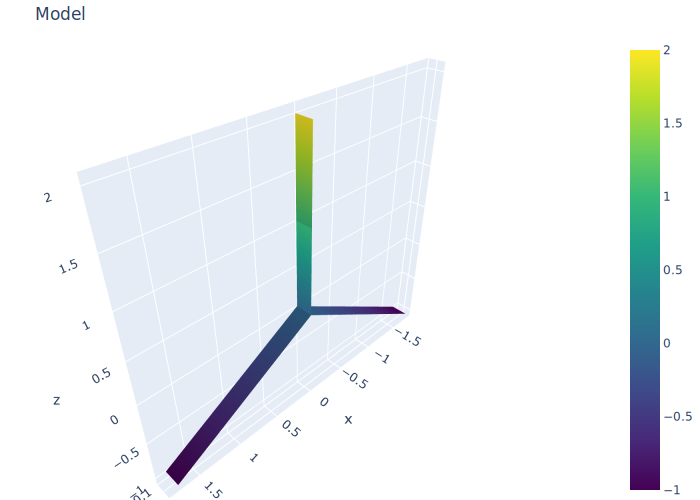

In [3]:
import meshio
import plotly.graph_objs as go
from IPython.display import SVG, display

mesh_data = meshio.read(target_1['model'])

fig = go.Figure()

fig.add_trace(go.Mesh3d(x=mesh_data.points[:, 0],
                        y=mesh_data.points[:, 1],
                        z=mesh_data.points[:, 2],
                        i=mesh_data.cells[0].data[:, 0],
                        j=mesh_data.cells[0].data[:, 1],
                        k=mesh_data.cells[0].data[:, 2],
                        intensity=mesh_data.points[:, 2],
                        colorscale='Viridis'
                        ))

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2.25, y=2.25, z=2.25)
)

fig.update_layout(
    title='Model',
    scene=dict(
        aspectmode='data',
        camera=camera,
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# fig.show()
display(SVG(fig.to_image(format='svg', scale=1)))

## Ray Tracing

Simulate rays. `level='sample'` defines ray tracing for each sample point. This is the most time-consuming setup but the most accurate.

In [4]:
from radarsimpy.rt import scene
import time

tic = time.time()
data = scene(radar, targets,
             density=0.2, level='sample', noise=True)
baseband = data['baseband']
timestamp = data['timestamp']
toc = time.time()

print('Exec time :'+str(toc-tic) + 's')

Exec time :659.4155638217926s


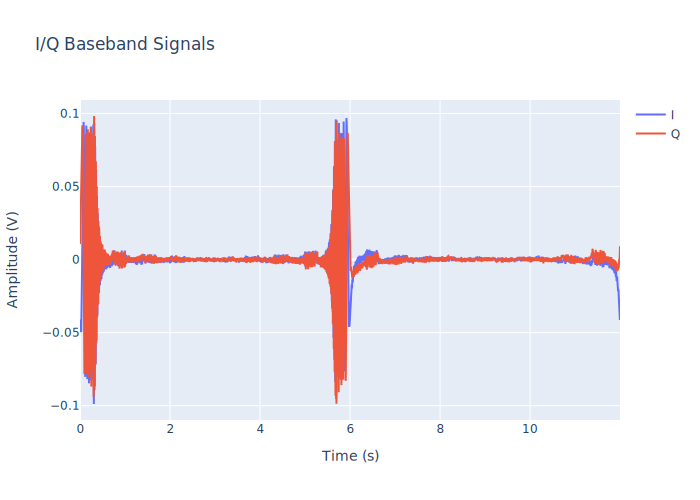

In [5]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=timestamp[0, 0, :],
    y=np.real(baseband[0, 0, :]),
    name='I',
))
fig.add_trace(go.Scatter(
    x=timestamp[0, 0, :],
    y=np.imag(baseband[0, 0, :]),
    name='Q',
))

fig.update_layout(
    title='I/Q Baseband Signals',
    yaxis=dict(title='Amplitude (V)'),
    xaxis=dict(title='Time (s)'),
)

# fig.show()
display(SVG(fig.to_image(format='svg', scale=1)))

## Short-Time Fourier Transform

In [6]:
from scipy.signal import stft

spec = stft(baseband[0, 0, :], fs=radar.receiver.fs,
            nperseg=64, noverlap=32, nfft=128, return_onesided=False)

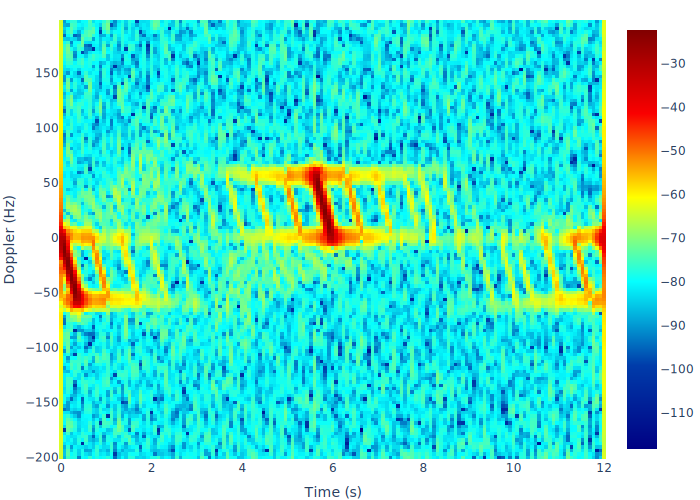

In [7]:
idx_neg = np.where(spec[0] < 0)
idx_pos = np.where(spec[0] >= 0)

dopp_ordered = spec[0][np.concatenate([idx_neg[0], idx_pos[0]])]

spec_shifted = spec[2][np.concatenate([idx_neg[0], idx_pos[0]]), :]

fig = go.Figure()

fig.add_trace(go.Heatmap(
    z=20*np.log10(np.abs(spec_shifted)),
    x=spec[1],
    y=dopp_ordered,
    hoverongaps=False,
    colorscale='Jet'))

fig.update_layout(
    yaxis=dict(title='Doppler (Hz)'),
    xaxis=dict(title='Time (s)'),
    margin=dict(l=0, r=0, b=0, t=20)
)

# fig.show()
display(SVG(fig.to_image(format='svg', scale=1)))